# Сборный проект №2

**Описание исследования**

HR-аналитики компании «Работа с заботой» помогают бизнесу оптимизировать управление персоналом: бизнес предоставляет данные, а аналитики предлагают, как избежать финансовых потерь и оттока сотрудников. В этом HR-аналитикам пригодится машинное обучение, с помощью которого получится быстрее и точнее отвечать на вопросы бизнеса.

Компания предоставила данные с характеристиками сотрудников компании. Среди них — уровень удовлетворённости сотрудника работой в компании. Эту информацию получили из форм обратной связи: сотрудники заполняют тест-опросник, и по его результатам рассчитывается доля их удовлетворённости от 0 до 1, где 0 — совершенно неудовлетворён, 1 — полностью удовлетворён. 

**Цель исследования**

Предсказать уровень удовлетворённости сотрудника и увольнение сотрудника из компании

**Задачи исследования**
- Построить модель, которая сможет предсказать уровень удовлетворённости сотрудника на основе данных заказчика. 
- Построить модель, которая сможет на основе данных заказчика предсказать то, что сотрудник уволится из компании.

**Исходные данные**

Первая задача: 

- Тренировочная выборка: `train_job_satisfaction_rate.csv`
- Входные признаки тестовой выборки: `test_features.csv`
- Целевой признак тестовой выборки: `test_target_job_satisfaction_rate.csv`

Вторая задача:

- Тренировочная выборка: `train_quit.csv`
- Входные признаки тестовой выборки те же, что и в прошлой задаче: `test_features.csv`
- Целевой признак тестовой выборки: `test_target_quit.csv`

## Table of Contents
* [Импортируем библиотеки](#chapter1)
* [Задача №1: предсказание уровня удовлетворённости сотрудника](#chapter2)
    * [Загрузка данных](#chapter3)
    * [Описание данных](#chapter4)
    * [Предобработка данных](#chapter5)
    * [Исследовательский анализ данных](#chapter6)
        * [Визуализация дискретных признаков](№chapter7)
        * [Визуализация количественных признаков](#chapter8)
        * [Визуализация категориальных признаков](#chapter9)
        * [Матрица корреляций количественных признаков](#chapter10)
    * [Пайплайн для подготовки данных](#chapter11)
    * [Функция метрики SMAPE](#chapter12)
    * [Обучение моделей](#chapter13)
        * [Подбор параметров с RandomizedSearchCV](#chapter14)
        * [Анализ важности признаков](#chapter15)
* [Задача 2: предсказание увольнения сотрудника из компании¶](#chapter17)
    * [Загрузка данных](#chapter18)
    * [Описание данных](#chapter19)
    * [Предобработка данных](#chapter20)
    * [Портер уволившегося сотрудника](#chapter21)
    * [Добавление нового признака](#chapter22)
    * [Пайплайн для подготовки данных](#chapter23)
    * [Обучение моделей](#chapter24)
* [Общий вывод](#chapter25)

<a class="anchor" id="chapter1"></a>
## Импортируем библиотеки

In [1]:
!pip install phik -q
!pip install shap -q
!pip install optuna -q
!pip install optuna-integration -q
!pip install scikit-learn --upgrade -q

In [2]:
import pandas as pd
import numpy as np


import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler, RobustScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import root_mean_squared_error

from optuna.integration import OptunaSearchCV 
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from optuna import distributions
import optuna
import shap

import warnings
warnings.filterwarnings("ignore")

<a class="anchor" id="chapter2"></a>

## Задача №1: предсказание уровня удовлетворённости сотрудника

<a class="anchor" id="chapter3"></a>
### Загрузка данных

In [3]:
try:
    train_data = pd.read_csv('train_job_satisfaction_rate.csv')
    X_test = pd.read_csv('test_features.csv')
    y_test = pd.read_csv('test_target_job_satisfaction_rate.csv')
except:
    train_data = pd.read_csv('/datasets/train_job_satisfaction_rate.csv')
    X_test = pd.read_csv('/datasets/test_features.csv')
    y_test = pd.read_csv('/datasets/test_target_job_satisfaction_rate.csv')

Как позже я выяснила, данные в файле с входными признаками тестовой выборки и данные в файле с целевым признакм тестовой выборки расположены не по порядку, поэтому нужно соединить входные и целевые признаки в один датафрейм по `id`

In [4]:
test_data = X_test.merge(y_test, on='id')
test_data.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,485046,marketing,junior,medium,2,no,no,5,28800,0.79
1,686555,hr,junior,medium,1,no,no,4,30000,0.72
2,467458,sales,middle,low,5,no,no,4,19200,0.64
3,418655,sales,middle,low,6,no,no,4,19200,0.60
4,789145,hr,middle,medium,5,no,no,5,40800,0.75


<a class="anchor" id="chapter4"></a>
### Описание данных

- `id` — уникальный идентификатор сотрудника;
- `dept` — отдел, в котором работает сотрудник;
- `level` — уровень занимаемой должности;
- `workload` — уровень загруженности сотрудника;
- `employment_years` — длительность работы в компании (в годах);
- `last_year_promo` — показывает, было ли повышение за последний год;
- `last_year_violations` — показывает, нарушал ли сотрудник трудовой договор за последний год;
- `supervisor_evaluation` — оценка качества работы сотрудника, которую дал руководитель;
- `salary` — ежемесячная зарплата сотрудника;
- `job_satisfaction_rate` — уровень удовлетворённости сотрудника работой в компании, целевой признак.

Посмотрим на первые пять строчек тренировочного датасета, общую информацио о таблице. Проверим, если есть пропущенные значения, явные и неявные дубликаты. 

In [5]:
train_data.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,155278,sales,junior,medium,2,no,no,1,24000,0.58
1,653870,hr,junior,high,2,no,no,5,38400,0.76
2,184592,sales,junior,low,1,no,no,2,12000,0.11
3,171431,technology,junior,low,4,no,no,2,18000,0.37
4,693419,hr,junior,medium,1,no,no,3,22800,0.20


In [6]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     4000 non-null   int64  
 1   dept                   3994 non-null   object 
 2   level                  3996 non-null   object 
 3   workload               4000 non-null   object 
 4   employment_years       4000 non-null   int64  
 5   last_year_promo        4000 non-null   object 
 6   last_year_violations   4000 non-null   object 
 7   supervisor_evaluation  4000 non-null   int64  
 8   salary                 4000 non-null   int64  
 9   job_satisfaction_rate  4000 non-null   float64
dtypes: float64(1), int64(4), object(5)
memory usage: 312.6+ KB


**Мини-вывод:**

- Загрузили и сохранили csv-файлы в переменные;
- Соединили входные и целевые признаки тестовой выборки в один датафрейм, чтобы установить один порядок в данных;
- По общей информации о датафрейме видно, что типы данных в столбцах имеют правильный вид, но есть пропущенные значения в двух признаках.

<a class="anchor" id="chapter5"></a>
### Предобработка данных

In [7]:
print(f'\nMissing Train Data: \n{train_data.isna().sum()}')
print(f'\nDuplicates: {train_data.duplicated().sum()}')


Missing Train Data: 
id                       0
dept                     6
level                    4
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
job_satisfaction_rate    0
dtype: int64

Duplicates: 0


In [8]:
# Проверим на наличие неявных дубликатов
for col in train_data.select_dtypes(include=['object']).columns:
    print(train_data[col].unique())

['sales' 'hr' 'technology' 'purchasing' 'marketing' nan]
['junior' 'middle' 'sinior' nan]
['medium' 'high' 'low']
['no' 'yes']
['no' 'yes']


**Мини-вывод:**

- Явные и неявные дубликаты в тренировочной выборке не были найдены;
- Типы данных в датафрейме стоят правильные 
- Присутствуют пропущенные значения, удалим их в пайплайне

<a class="anchor" id="chapter6"></a>
### Исследовательский анализ данных

<a class="anchor" id="chapter7"></a>
#### Визуализация дискретных признаков

In [9]:
discrete_features = ['employment_years', 'supervisor_evaluation']

interval_features = ['salary', 'job_satisfaction_rate']

categorical_features = ['dept', 'level', 'workload', 'last_year_promo', 'last_year_violations']

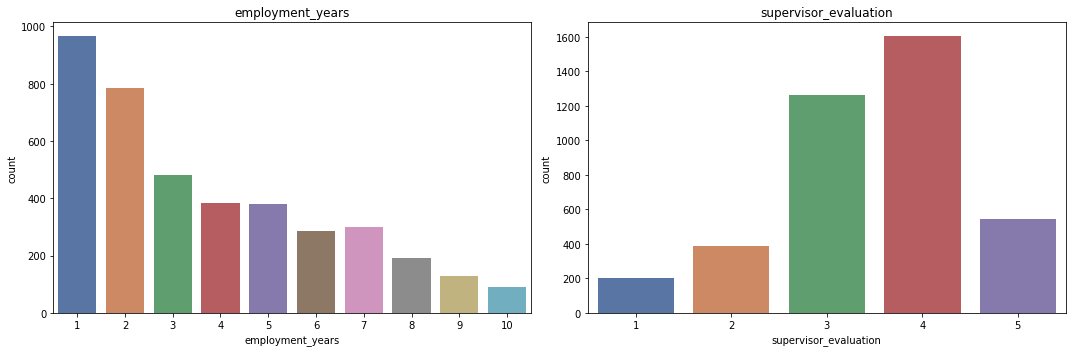

In [10]:
def plot_discrete_features(df, descrite_cols):
    num_plots = len(descrite_cols)
    num_rows = (num_plots + 1) // 2 
    num_cols = 2

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5 * num_rows))
    axes = axes.ravel() 
    for i, col in enumerate(descrite_cols):
        sns.countplot(x=col, data=df, ax=axes[i], palette='deep')
        axes[i].set_title(col)

    for i in range(num_plots, len(axes)):
        fig.delaxes(axes[i])

    plt.tight_layout()
    plt.show()
    
plot_discrete_features(df=train_data, descrite_cols=discrete_features)

In [11]:
print(f"Распределение признака employment_years \n{train_data['employment_years'].value_counts(normalize=True)}")
print(f"\nСтатистический анализ признака supervisor_evaluation \n{train_data['supervisor_evaluation'].describe()}")

Распределение признака employment_years 
1     0.24150
2     0.19625
3     0.12075
4     0.09600
5     0.09500
7     0.07525
6     0.07175
8     0.04825
9     0.03250
10    0.02275
Name: employment_years, dtype: float64

Статистический анализ признака supervisor_evaluation 
count    4000.000000
mean        3.476500
std         1.008812
min         1.000000
25%         3.000000
50%         4.000000
75%         4.000000
max         5.000000
Name: supervisor_evaluation, dtype: float64


- 24% сотрудников имеют стаж длиною в один год, максимальный стаж сотрудников 10 лет
- Средняя оценка качества работы сотрудника, выставленная руководителем, равна 3.47.

<a class="anchor" id="chapter8"></a>
#### Визуализация количественных признаков

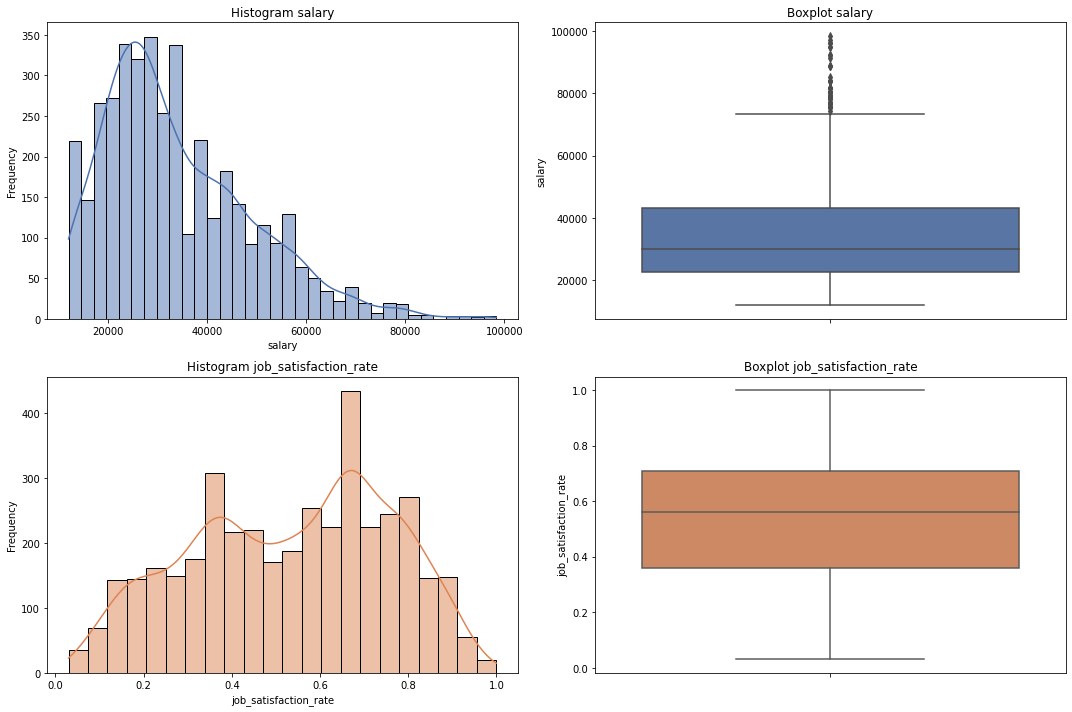

In [12]:
def plot_numerical_features(df, numerical_cols):
    palette = sns.color_palette('deep', len(numerical_cols))
    color_dict = dict(zip(numerical_cols, palette))
    num_cols = len(numerical_cols)
    fig, axes = plt.subplots(nrows=num_cols, ncols=2, figsize=(15, 5*num_cols)) 

    for i, col in enumerate(numerical_cols):
        # Histogram
        sns.histplot(data=df, x=col, kde=True, ax=axes[i, 0], color=color_dict[col]) 
        axes[i, 0].set_title(f'Histogram {col}')
        axes[i, 0].set_xlabel(col)
        axes[i, 0].set_ylabel('Frequency')

        # Boxplot
        sns.boxplot(y=df[col], ax=axes[i, 1], color=color_dict[col])
        axes[i, 1].set_title(f'Boxplot {col}')
        axes[i, 1].set_ylabel(col)

    plt.tight_layout() 
    plt.show()


plot_numerical_features(train_data, interval_features)

In [13]:
print(f"Статистический анализ признака salary \n{train_data['salary'].describe()}")
print(f"\nСтатистический анализ признака job_satisfaction_rate \n{train_data['job_satisfaction_rate'].describe()}")

Статистический анализ признака salary 
count     4000.000000
mean     33926.700000
std      14900.703838
min      12000.000000
25%      22800.000000
50%      30000.000000
75%      43200.000000
max      98400.000000
Name: salary, dtype: float64

Статистический анализ признака job_satisfaction_rate 
count    4000.000000
mean        0.533995
std         0.225327
min         0.030000
25%         0.360000
50%         0.560000
75%         0.710000
max         1.000000
Name: job_satisfaction_rate, dtype: float64


- Распределение признака `salary` ассиметричное, имеет левосторонний сдвиг
- Средняя зарплата сотрудников в компании - 33926.7
- Распределение признака `job_satisfaction_rate` ассиметричное
- Среднее значение уровня удовлетворенности работой сотрудника - 0.53

<a class="anchor" id="chapter9"></a>
#### Визуализация категориальных признаков

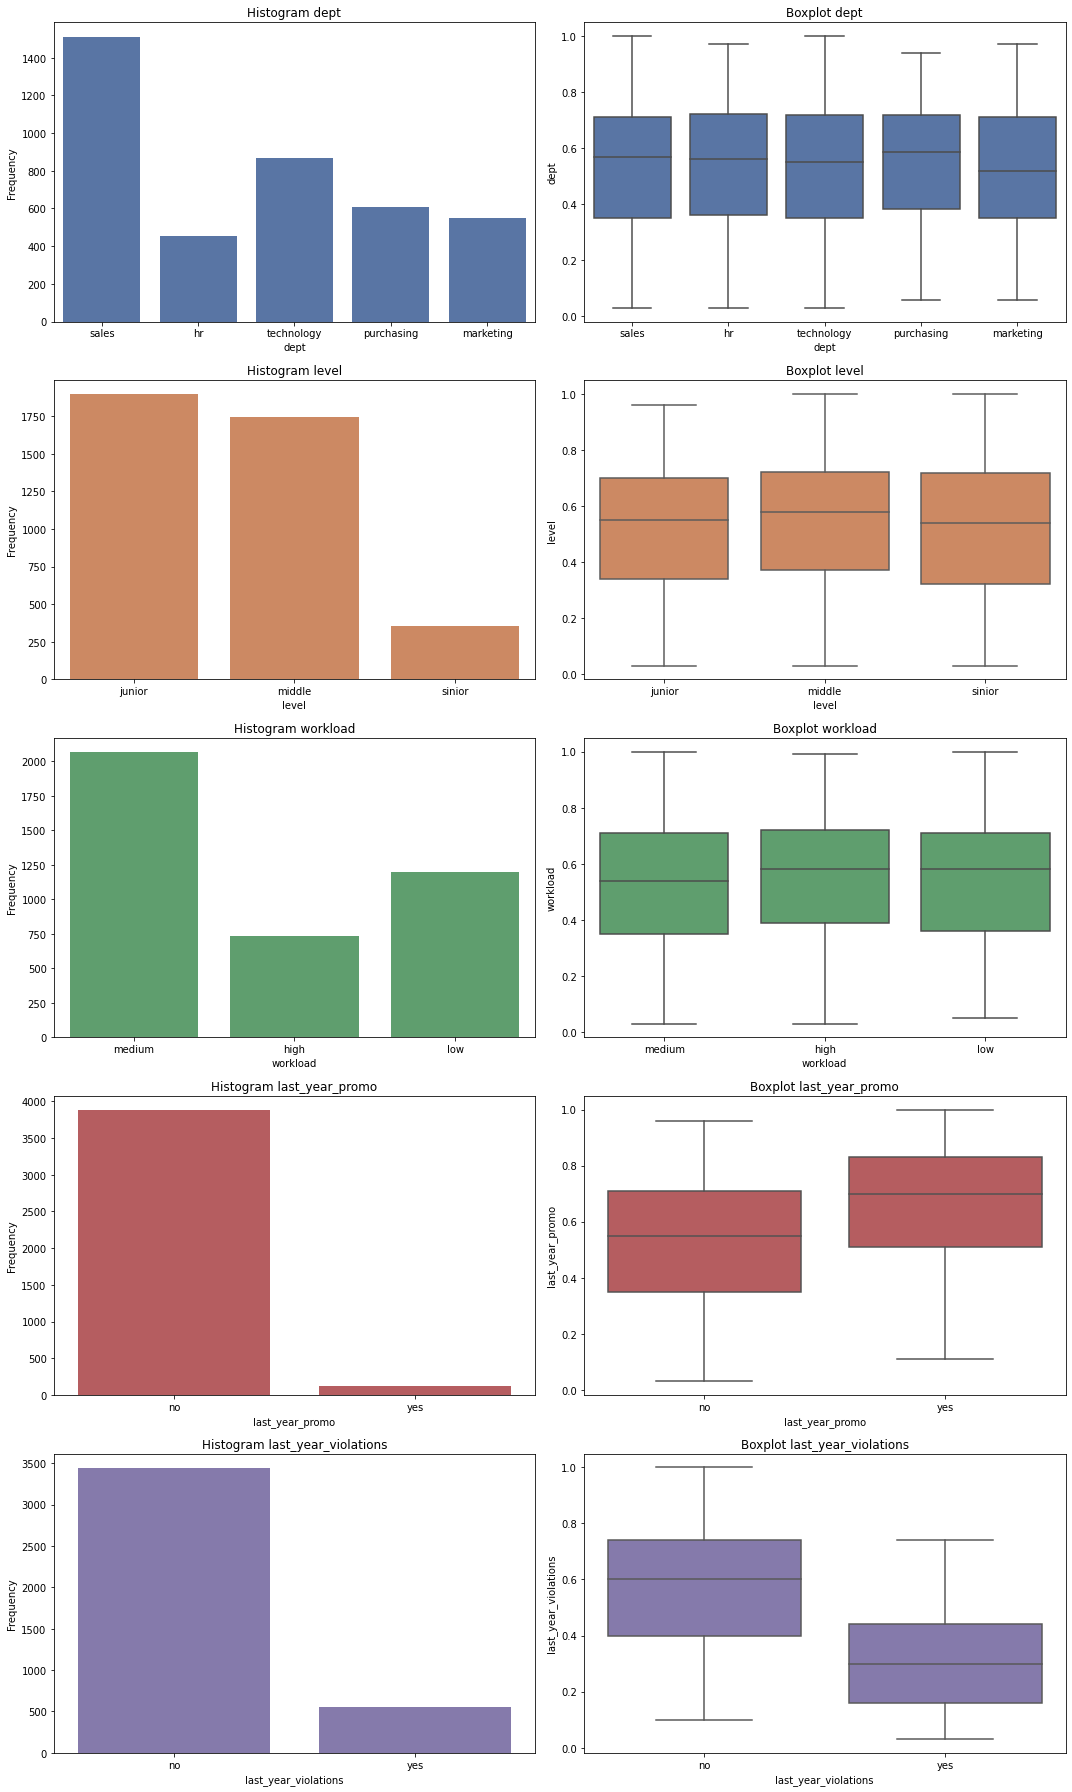

In [14]:
def plot_categorical_features(df, categorical_cols, target_column):
    palette = sns.color_palette('deep', len(categorical_cols))
    color_dict = dict(zip(categorical_cols, palette))
    cat_cols = len(categorical_cols)
    fig, axes = plt.subplots(nrows=cat_cols, ncols=2, figsize=(15, 5*cat_cols)) 

    for i, col in enumerate(categorical_cols):
        # Histogram
        sns.countplot(data=df, x=col, ax=axes[i, 0], color=color_dict[col]) 
        axes[i, 0].set_title(f'Histogram {col}')
        axes[i, 0].set_xlabel(col)
        axes[i, 0].set_ylabel('Frequency')

        # Boxplot
        sns.boxplot(x=df[col], y=df[target_column], ax=axes[i, 1], color=color_dict[col])
        axes[i, 1].set_title(f'Boxplot {col}')
        axes[i, 1].set_ylabel(col)

    plt.tight_layout() 
    plt.show()


plot_categorical_features(train_data, categorical_features, target_column='job_satisfaction_rate')

In [15]:
train_data.groupby('dept')['job_satisfaction_rate'].mean().reset_index().sort_values(by='job_satisfaction_rate',
                                                                                     ascending=False)

,dept,job_satisfaction_rate
2,purchasing,0.551967
0,hr,0.535680
3,sales,0.533757
4,technology,0.526467
1,marketing,0.524036


In [16]:
train_data['level'].value_counts(normalize=True)

junior    0.473974
middle    0.436436
sinior    0.089590
Name: level, dtype: float64

In [17]:
train_data.groupby('workload')['job_satisfaction_rate'].mean().reset_index().sort_values(by='job_satisfaction_rate',
                                                                                     ascending=False)

,workload,job_satisfaction_rate
0,high,0.546921
1,low,0.540592
2,medium,0.525571


In [18]:
train_data.groupby('last_year_promo')['job_satisfaction_rate'].mean().reset_index().sort_values(by='job_satisfaction_rate',
                                                                                     ascending=False)

,last_year_promo,job_satisfaction_rate
1,yes,0.673000
0,no,0.529696


In [19]:
train_data.groupby('last_year_violations')['job_satisfaction_rate'].mean().reset_index().sort_values(by='job_satisfaction_rate',
                                                                                     ascending=False)

,last_year_violations,job_satisfaction_rate
0,no,0.568759
1,yes,0.320000


- Самый высокий уровень удовлетворенности работой у сотрудника в отделе "purchasing	"
- Сотрудники уровня senior составляют всего 8% от общего количества сотрудников в компании, когда сотрудники уровней junior и middle составляют 47,3% и 43,6% соответственно
- Сотрудники с высокой загруженностью имеют более высокий уровень удовлетворенности работой
- Сотрудники, получившие повышение за последний год, имеют более высокий уровень удовлетворенности работой, чем сотрудники, не получившие повышение
- Сотрудники, нарушавший трудовой договор за последний год, имеют более высокий уровень удовлетворенности работой

**Мини-вывод:**

- Построили столбчатые диаграммы для дискретных признаков
- Построили гистограмму и "ящик с усами" для непрерывных признаков
- Построили столбчатую диаграмму и "ящик с усами" с учетом целевого признака для категориальных признаков

<a class="anchor" id="chapter10"></a>
#### Матрица корреляций количественных признаков

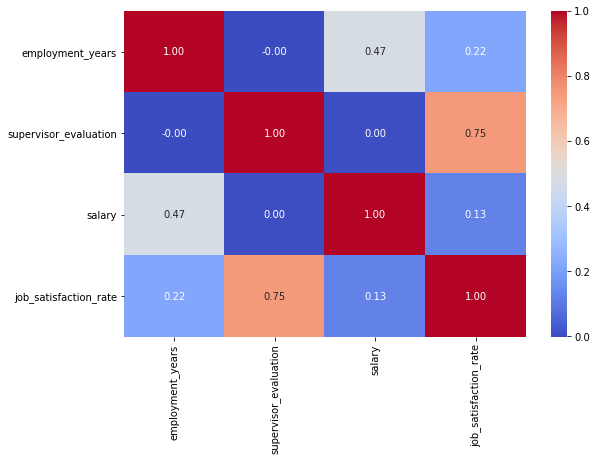

In [20]:
plt.figure(figsize = (9, 6))
sns.heatmap(train_data[[col for col in train_data.select_dtypes(include=['number']).columns if col != 'id']]
            .corr(method='spearman'), annot=True, fmt='.2f', cmap='coolwarm')
plt.show()

- Наблюдается умеренная линейная связь между признаками `employment_years` и `salary`, коэффициент Пирсона равен 0,47. Очевидно, что чем больше стаж у сотрудника, тем выше его заработная плата. 

- Есть высокая связь между признаками `job_satisfaction_rate` и `supervisor_evaluation` (0.75). Чем выше уровень удовлетворенности сотрудника, тем выше оценка его работы руководителем.  

- Проиндексируем столбец `id`
- Разделим данные на входные и целевые признаки в тренировочном и тестовом датасетах
- Удалим новые дубликаты

In [21]:
train_data_indexed = train_data.set_index('id')
train_data_indexed.head()

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
id,,,,,,,,,
155278,sales,junior,medium,2,no,no,1,24000,0.58
653870,hr,junior,high,2,no,no,5,38400,0.76
184592,sales,junior,low,1,no,no,2,12000,0.11
171431,technology,junior,low,4,no,no,2,18000,0.37
693419,hr,junior,medium,1,no,no,3,22800,0.20


In [22]:
print(f'Было: {train_data_indexed.duplicated().sum()}')
train_data_indexed.drop_duplicates(inplace=True)
print(f'Стало: {train_data_indexed.duplicated().sum()}')

Было: 245
Стало: 0


In [23]:
X_train = train_data_indexed.drop(columns=['job_satisfaction_rate'])
y_train = train_data_indexed['job_satisfaction_rate']

In [24]:
duplicates = X_train[X_train.duplicated(keep=False)]

duplicate_indices = duplicates.index

In [25]:
X_train = X_train.drop(duplicate_indices)
y_train = y_train.drop(duplicate_indices)

print(f'Размер X_train {X_train.shape}')
print(f'Размер y_train {y_train.shape}')

Размер X_train (1884, 8)
Размер y_train (1884,)


In [26]:
X_test = test_data.drop(columns='job_satisfaction_rate')
y_test = test_data['job_satisfaction_rate']

<a class="anchor" id="chapter11"></a>
### Пайплайн для подготовки данных

Сохраним в отдельные переменные категориальные, ранговые и количественные признаки

In [27]:
num_col_names = ['employment_years', 'supervisor_evaluation', 'salary']

cat_col_names = ['dept', 'last_year_promo', 'last_year_violations']

ord_col_names = ['level', 'workload']

In [28]:
RANDOM_STATE = 42

ohe_pipe = Pipeline(
    [
        (
            'simpleImputer_ohe', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'ohe', 
            OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False)
        )
    ]
)


ord_pipe = Pipeline(
    [
        (
            'simpleImputer_before_ord', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'ord',
            OrdinalEncoder(
                categories=[
                    ['junior' 'middle' 'sinior'],
                    ['low', 'medium', 'high']
                ], 
                handle_unknown='use_encoded_value',
                unknown_value=np.nan
            )
        ),
        (
            'simpleImputer_after_ord', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        )
    ]
)

data_preprocessor = ColumnTransformer(
    [
        ('ohe', ohe_pipe, cat_col_names),
        ('ord', ord_pipe, ord_col_names),
        ('num', StandardScaler(), num_col_names)
    ], 
    remainder='passthrough'
) 

<a class="anchor" id="chapter12"></a>
### Функция метрики SMAPE

In [29]:
def smape(y_true, y_pred):
    smap = np.zeros(len(y_true))
    
    num = np.abs(y_true - y_pred)
    dem = ((np.abs(y_true) + np.abs(y_pred)) / 2)
    
    pos_ind = dem != 0
    smap[pos_ind] = num[pos_ind] / dem[pos_ind]
    
    return 100 * np.mean(smap)

<a class="anchor" id="chapter13"></a>
### Обучение моделей

<a class="anchor" id="chapter14"></a>
#### Подбор параметров с RandomizedSearchCV

Возьмем две модели DecisionTreeRegressor() и LinearRegression() и с помощью RandomizedSearchCV автоматически подберем гиперпараметры и найдем лучшую модель

In [30]:
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', DecisionTreeRegressor(random_state=RANDOM_STATE))
])

param_grid = [
    # словарь для модели DecisionTreeRegressor()
    {
        'models': [DecisionTreeRegressor(random_state=RANDOM_STATE)],
        'models__max_depth': range(1, 20),
        'models__min_samples_leaf': range(1, 10),
        'models__min_samples_split': range(2, 10),
        'models__splitter': ['best', 'random'],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },

    # словарь для модели LinearRegression()
    {
        'models': [LinearRegression()],
        'models__copy_X': [True, False],
        'models__fit_intercept': [True, False], 
        'models__n_jobs': [1,5,10,15,None],
        'models__positive': [True, False],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    }
]

randomized_search = RandomizedSearchCV(
    pipe_final, 
    param_grid, 
    cv=5,
    scoring='neg_mean_squared_error',
    random_state=RANDOM_STATE,
    n_jobs=-1
)
randomized_search.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('ohe',
                                                                               Pipeline(steps=[('simpleImputer_ohe',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('ohe',
                                                                                                OneHotEncoder(drop='first',
                                                                                                              handle_unknown='ignore',
                                                                                                              sparse_output=False))]),
                                                                               ['dept',
                                                                                'last_year_promo',
                                                                                'last_year_violations']),
                                                                              ('ord',
                                                                               Pip...
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               'passthrough']},
                                        {'models': [LinearRegression()],
                                         'models__copy_X': [True, False],
                                         'models__fit_intercept': [True, False],
                                         'models__n_jobs': [1, 5, 10, 15, None],
                                         'models__positive': [True, False],
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               'passthrough']}],
                   random_state=42, scoring='neg_mean_squared_error')

In [31]:
print('Лучшая модель и её параметры:\n\n', randomized_search.best_estimator_)
print ('Метрика лучшей модели на кросс-валидации:', randomized_search.best_score_)

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['dept', 'last_year_promo',
                                                   'last_year_violations']),
                                                 ('ord',
                            

In [32]:
predictions = randomized_search.predict(X_test)
print(f'Метрика SMAPE на тестовой выборке {smape(y_test, predictions)}')

Метрика SMAPE на тестовой выборке 18.00247843923853


Лучшей моделью стала модель DecisionTreeRegressor, и ее метрика на тестовой выборке равна 18.002

<a class="anchor" id="chapter15"></a>
#### Анализ важности признаков

In [33]:
best_model = randomized_search.best_estimator_
X_train_prepr = best_model.named_steps['preprocessor'].transform(X_train)
X_test_prepr = best_model.named_steps['preprocessor'].transform(X_test)
feature_names = list(best_model.named_steps['preprocessor'].get_feature_names_out())

# Возьмем 100 примеров из выборок 
X_train_sample = shap.sample(X_train_prepr, 100)
X_test_sample = shap.sample(X_test_prepr, 100)
explainer = shap.KernelExplainer(best_model.named_steps['models'].predict, X_train_sample)
shap_values = explainer(X_test_sample)

  0%|          | 0/100 [00:00<?, ?it/s]

In [34]:
# Преобразование SHAP значений в объект Explanation
"""
base_values = np.repeat(explainer.expected_value, X_test_sample.shape[0])
shap_values_exp = shap.Explanation(values=shap_values, base_values=base_values,
                                   data=X_test_sample, feature_names=feature_names)

# Построим график общей значимости признаков
shap.plots.bar(shap_values_exp, max_display=21)
"""

'\nbase_values = np.repeat(explainer.expected_value, X_test_sample.shape[0])\nshap_values_exp = shap.Explanation(values=shap_values, base_values=base_values,\n                                   data=X_test_sample, feature_names=feature_names)\n\n# Построим график общей значимости признаков\nshap.plots.bar(shap_values_exp, max_display=21)\n'

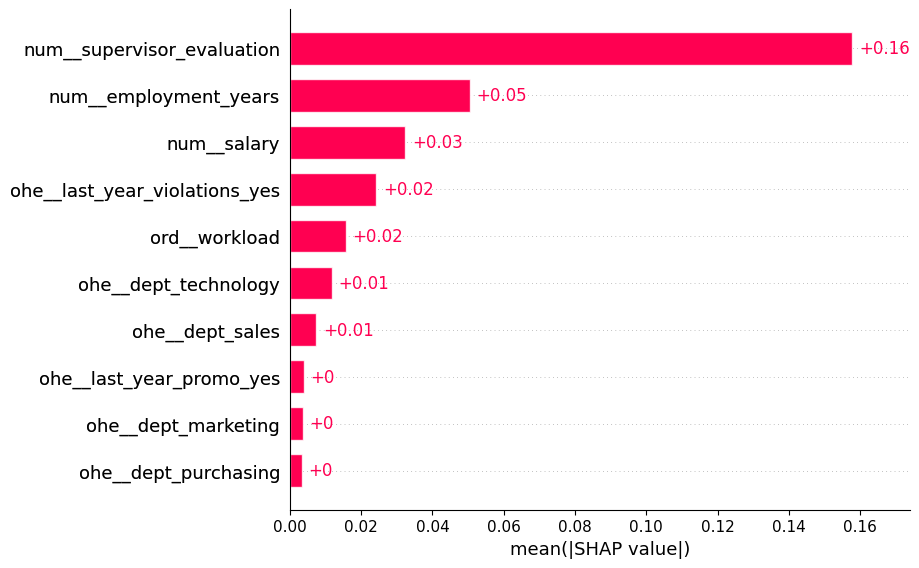

Признаки на графике расположены в порядке убывания их вклада: начиная с самого важного признака и заканчивая самым малозначимым для модели признаком. Лидирует признак `supervisor_evaluation`, а вторым по значимости является признак `employment_years`. 

**Мини-вывод:**
    
Построили две модели регрессии, чтобы предсказать уровень удовлетворенности работника - LinearRegression с GridSearchCV и DecisionTreeRegressor с Optuna. Лучшей оказалась модель DecisionTreeRegressor и ее результаты на метрике SMAPE равны 14.78. Провели анализ признаков с помощью shap, и оказалось, что `supervisor_evaluation` и `employment_years` влияют на принятие решений моделью больше других признаков. 

<a class="anchor" id="chapter17"></a>

## Задача 2: предсказание увольнения сотрудника из компании

<a class="anchor" id="chapter18"></a>
### Загрузка данных

In [35]:
try:
    train_df = pd.read_csv('train_quit.csv')
    test_X = pd.read_csv('test_features (1).csv')
    test_y = pd.read_csv('test_target_quit.csv')
except:
    train_df = pd.read_csv('/datasets/train_quit.csv')
    test_X = pd.read_csv('/datasets/test_features.csv')
    test_y = pd.read_csv('/datasets/test_target_quit.csv')

Соединим входные и целевые признаки в один датафрейм по `id`

In [36]:
test_df = test_X.merge(test_y, on='id')
test_df.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
0,485046,marketing,junior,medium,2,no,no,5,28800,no
1,686555,hr,junior,medium,1,no,no,4,30000,no
2,467458,sales,middle,low,5,no,no,4,19200,no
3,418655,sales,middle,low,6,no,no,4,19200,no
4,789145,hr,middle,medium,5,no,no,5,40800,no


<a class="anchor" id="chapter19"></a>
### Описание данных

Выведем первые пять строчек тренировочного датасета и общую информацию о нем

In [37]:
train_df.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
0,723290,sales,middle,high,2,no,no,4,54000,no
1,814010,sales,junior,medium,2,no,no,4,27600,no
2,155091,purchasing,middle,medium,5,no,no,1,37200,no
3,257132,sales,junior,medium,2,no,yes,3,24000,yes
4,910140,marketing,junior,medium,2,no,no,5,25200,no


In [38]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     4000 non-null   int64 
 1   dept                   4000 non-null   object
 2   level                  4000 non-null   object
 3   workload               4000 non-null   object
 4   employment_years       4000 non-null   int64 
 5   last_year_promo        4000 non-null   object
 6   last_year_violations   4000 non-null   object
 7   supervisor_evaluation  4000 non-null   int64 
 8   salary                 4000 non-null   int64 
 9   quit                   4000 non-null   object
dtypes: int64(4), object(6)
memory usage: 312.6+ KB


**Мини-вывод:**

Загрузили и сохранили csv-файлы в переменные. Как и в первой задаче, соединили входные и целевой признаки в один датафрейм, чтобы получить один и тот же порядок в данных. По общей информации о датафейме выяснили, что пропущенных значений в таблице нет, и типы данных стоят правильные. 

<a class="anchor" id="chapter20"></a>
### Предобработка данных

In [39]:
print(f'\nMissing Train Data: \n{train_df.isna().sum()}')
print(f'\nDuplicates: {train_df.duplicated().sum()}')


Missing Train Data: 
id                       0
dept                     0
level                    0
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
quit                     0
dtype: int64

Duplicates: 0


In [40]:
# Проверим на наличие неявных дубликатов
for col in train_df.select_dtypes(include=['object']).columns:
    print(train_df[col].unique())

['sales' 'purchasing' 'marketing' 'technology' 'hr']
['middle' 'junior' 'sinior']
['high' 'medium' 'low']
['no' 'yes']
['no' 'yes']
['no' 'yes']


**Мини-вывод:**

- Явные и неявные дубликаты в тренировочной выборке не были найдены;
- Типы данных в датафрейме стоят правильные 
- Пропущенных значений нет

<a class="anchor" id="chapter21"></a>
### Портрет уволившегося сотрудника 

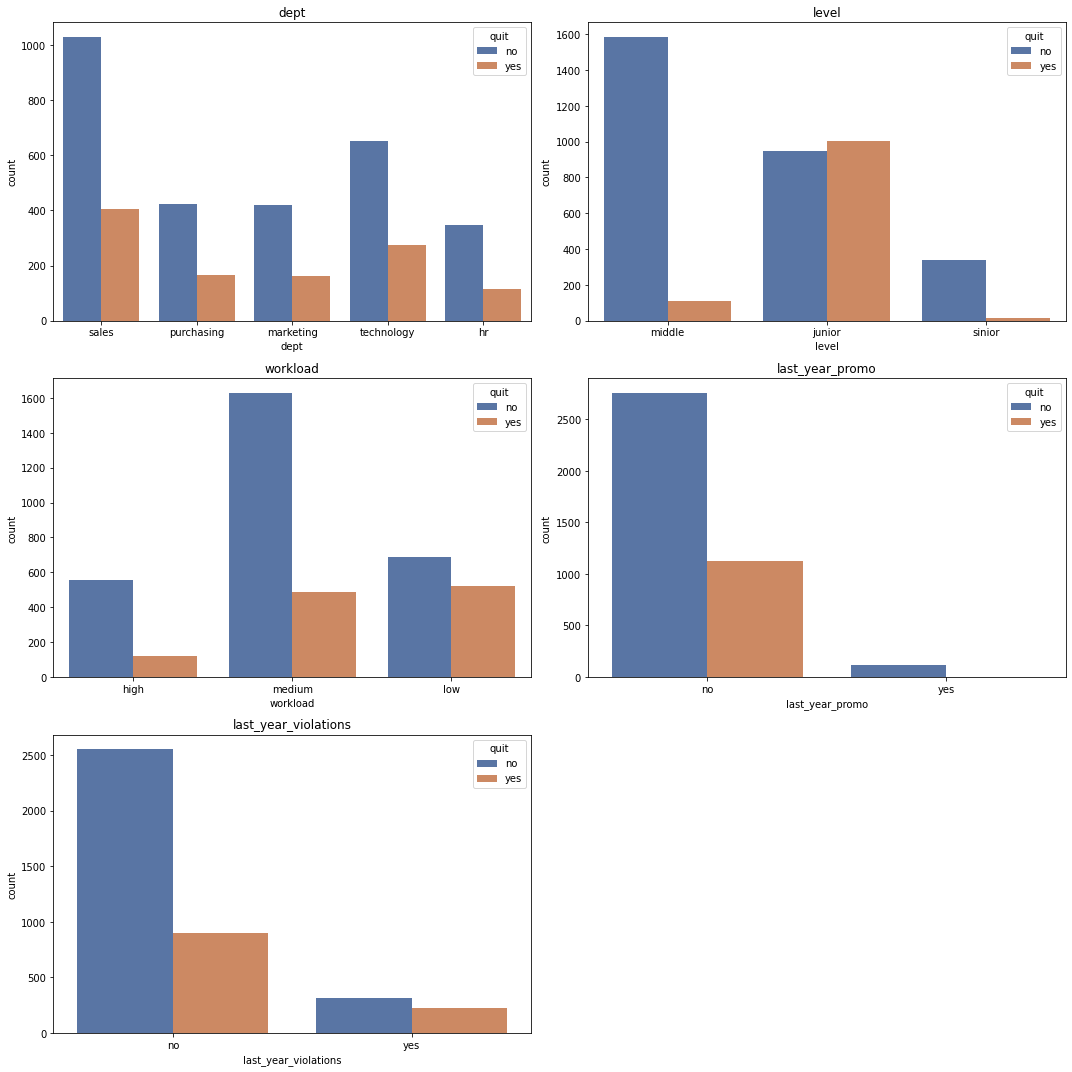

In [41]:
categorical_features = ['dept', 'level', 'workload', 'last_year_promo', 'last_year_violations']

num_plots = len(categorical_features)
num_rows = (num_plots + 1) // 2 
num_cols = 2

fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5 * num_rows))
axes = axes.ravel() 
for i, col in enumerate(categorical_features):
    sns.countplot(x=col, hue='quit', data=train_df, ax=axes[i], palette='deep')
    axes[i].set_title(col)

for i in range(num_plots, len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

Рассчитаем соотношение уволившихся сотрудников к общему количеству в каждом отделе, и для этого преобразуем колонку `quit` в булев тип и построим сводную таблицу

In [42]:
temp_train_df = train_df.copy()
temp_train_df['quit'] = temp_train_df['quit'] == 'yes'

temp_train_df.groupby('dept').agg(total_quit=('quit', 'sum'),
                             total_workers=('quit', 'count')).assign(
                            prctg_quit=lambda x: x['total_quit'] / x['total_workers'] * 100).sort_values(
                            by='prctg_quit', ascending=False)

,total_quit,total_workers,prctg_quit
dept,,,
technology,276,928,29.741379
sales,407,1438,28.303199
purchasing,166,588,28.231293
marketing,163,582,28.006873
hr,116,464,25.000000


In [43]:
temp_train_df.groupby('level').agg(total_quit=('quit', 'sum'),
                             total_workers=('quit', 'count')).assign(
                            prctg_quit=lambda x: x['total_quit'] / x['total_workers'] * 100).sort_values(
                            by='prctg_quit', ascending=False)

,total_quit,total_workers,prctg_quit
level,,,
junior,1003,1949,51.462288
middle,108,1694,6.375443
sinior,17,357,4.761905


In [44]:
temp_train_df.groupby('workload').agg(total_quit=('quit', 'sum'),
                             total_workers=('quit', 'count')).assign(
                            prctg_quit=lambda x: x['total_quit'] / x['total_workers'] * 100).sort_values(
                            by='prctg_quit', ascending=False)

,total_quit,total_workers,prctg_quit
workload,,,
low,519,1208,42.963576
medium,488,2118,23.040604
high,121,674,17.952522


In [45]:
temp_train_df.groupby('last_year_promo').agg(total_quit=('quit', 'sum'),
                             total_workers=('quit', 'count')).assign(
                            prctg_quit=lambda x: x['total_quit'] / x['total_workers'] * 100).sort_values(
                            by='prctg_quit', ascending=False)

,total_quit,total_workers,prctg_quit
last_year_promo,,,
no,1127,3887,28.994083
yes,1,113,0.884956


In [46]:
temp_train_df.groupby('last_year_violations').agg(total_quit=('quit', 'sum'),
                             total_workers=('quit', 'count')).assign(
                            prctg_quit=lambda x: x['total_quit'] / x['total_workers'] * 100).sort_values(
                            by='prctg_quit', ascending=False)

,total_quit,total_workers,prctg_quit
last_year_violations,,,
yes,228,545,41.834862
no,900,3455,26.049204


,quit,salary
0,no,37702.228412
1,yes,23885.106383


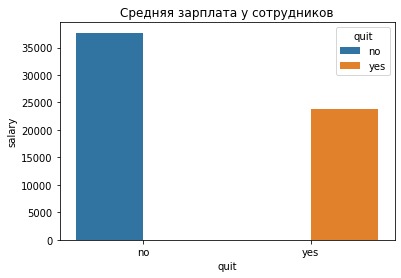

In [47]:
salary_agg = train_df.groupby('quit')['salary'].mean().reset_index()
display(salary_agg)
sns.barplot(data=salary_agg, x='quit', y='salary', hue='quit')
plt.title('Средняя зарплата у сотрудников')
plt.show()

- В отделе `technology` самый высокий процент уволившихся сотрудников (29.7%)
- 51.4% сотрудников уровня junior уволились из компании, когда из сотрудников уровней middle и senior всего 6,37% и 4,76% соответственно
- 42% сотрудников с низкой загруженностью увольняются с работы
- 28.9% cотрудников, не получивших повышение за последний угод, покинули компанию
- 41.8% cотрудников, нарушавших трудовой договор за последний год, уволились из компании
- Средняя зарплата у уволившихся сотрудников меньше, чем у оставшихся

Добавим из тестовой выборки первой задачи признак `job_satisfaction_rate` к тестовому датасету второй задачи

In [48]:
test_df_merged = test_df.merge(test_data[['id', 'job_satisfaction_rate']], on='id')
test_df_merged.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit,job_satisfaction_rate
0,485046,marketing,junior,medium,2,no,no,5,28800,no,0.79
1,686555,hr,junior,medium,1,no,no,4,30000,no,0.72
2,467458,sales,middle,low,5,no,no,4,19200,no,0.64
3,418655,sales,middle,low,6,no,no,4,19200,no,0.60
4,789145,hr,middle,medium,5,no,no,5,40800,no,0.75


,quit,job_satisfaction_rate
0,no,0.612040
1,yes,0.387713


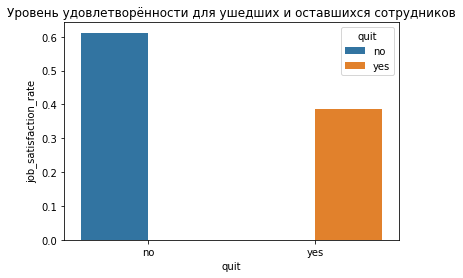

In [49]:
job_satisfaction_agg = test_df_merged.groupby('quit')['job_satisfaction_rate'].mean().reset_index()
display(job_satisfaction_agg)
sns.barplot(data=job_satisfaction_agg, x='quit', y='job_satisfaction_rate', hue='quit')
plt.title('Уровень удовлетворённости для ушедших и оставшихся сотрудников')
plt.show()

На графике видно, что уровень удовлетворенности работой выше у оставшихся выше, чем у уволившихся

**Мини-вывод:**

Уволивший сотрудник это скорее всего:
- специалист уровня junior
- из отдела technology
- с низкой загруженностью
- не получивший повышение на должности за последний год
- нарушал трудовой договор
- с низкой зарплатой
- с низким уровнем удовлетворенности работой 

**Разделим данные на входные и целевой признаки**

In [50]:
train_df_indexed = train_df.set_index('id')
new_X_train = train_df_indexed.drop(columns='quit')
new_y_train = train_df_indexed['quit']

duplicates = new_X_train[new_X_train.duplicated(keep=False)]

duplicate_indices = duplicates.index

new_X_train = new_X_train.drop(duplicate_indices)
new_y_train = new_y_train.drop(duplicate_indices)

print(f'Размер new_X_train {new_X_train.shape}')
print(f'Размер new_y_train {new_y_train.shape}')

Размер new_X_train (1796, 8)
Размер new_y_train (1796,)


In [51]:
new_X_test = test_df_merged.drop(columns='quit')
new_y_test = test_df_merged['quit']

<a class="anchor" id="chapter22"></a>
### Добавление нового признака

Используя лучшую модель из первой задачи, предскажем признак `job_satisfaction_rate` для тренировочной выборки второго задания

In [52]:
new_X_train_preprocessed = best_model.named_steps['preprocessor'].transform(new_X_train[num_col_names+cat_col_names+ord_col_names])
new_predictions = best_model.named_steps['models'].predict(new_X_train_preprocessed)
new_X_train['job_satisfaction_rate'] = new_predictions

Теперь определим новые столбцы для второй задачи

In [53]:
new_num_col = ['employment_years', 'supervisor_evaluation', 'salary', 'job_satisfaction_rate']

new_cat_col = ['dept', 'last_year_promo', 'last_year_violations']

new_ord_col = ['level', 'workload']

<a class="anchor" id="chapter23"></a>
### Пайплайн для подготовки данных

Закодируем целевой признак с помощью класса `LabelEncoder`

In [54]:
label_encoder = LabelEncoder()
label_encoder.fit(['no', 'yes'])

new_y_train = label_encoder.transform(new_y_train)
new_y_test = label_encoder.transform(new_y_test) 

Так как во второй задаче был добавлен новый признак `job_satisfaction_rate`, то создадим новый пайплайн для подготовки данных

In [55]:
new_data_preprocessor = ColumnTransformer(
    [
        ('ohe', ohe_pipe, new_cat_col),
        ('ord', ord_pipe, new_ord_col),
        ('num', StandardScaler(), new_num_col)
    ], 
    remainder='passthrough'
) 

<a class="anchor" id="chapter24"></a>
### Обучение моделей

Обучим три модели DecisionTreeClassifier(), KNeighborsClassifier(), LogisticRegression() и с помощью RandomizedSearchCV найдем лучшую модель, подобрав гиперпараметры. 

In [56]:
pipe_final = Pipeline([
    ('preprocessor', new_data_preprocessor),
    ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
])

param_grid = [
    # словарь для модели DecisionTreeClassifier()
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__min_samples_split': range(2, 11),
        'models__min_samples_leaf': range(1, 11),
        'models__max_depth': range(2, 11),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
    
    # словарь для модели KNeighborsClassifier() 
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(2, 11),
        'models__metric': ['manhattan', 'euclidean'],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']   
    },

    # словарь для модели LogisticRegression()
    {
        'models': [LogisticRegression(
            random_state=RANDOM_STATE, 
            solver='liblinear', 
            penalty='l1'
        )],
        'models__C': range(1, 5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    }
]

randomized_search = RandomizedSearchCV(
    pipe_final, 
    param_grid, 
    cv=5,
    scoring='roc_auc',
    random_state=RANDOM_STATE,
    n_jobs=-1
)
randomized_search.fit(new_X_train, new_y_train)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('ohe',
                                                                               Pipeline(steps=[('simpleImputer_ohe',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('ohe',
                                                                                                OneHotEncoder(drop='first',
                                                                                                              handle_unknown='ignore',
                                                                                                              sparse_output=False))]),
                                                                               ['dept',
                                                                                'last_year_promo',
                                                                                'last_year_violations']),
                                                                              ('ord',
                                                                               Pip...
                                         'models__metric': ['manhattan',
                                                            'euclidean'],
                                         'models__n_neighbors': range(2, 11),
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               'passthrough']},
                                        {'models': [LogisticRegression(penalty='l1',
                                                                       random_state=42,
                                                                       solver='liblinear')],
                                         'models__C': range(1, 5),
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               'passthrough']}],
                   random_state=42, scoring='roc_auc')

In [57]:
print('Лучшая модель и её параметры:\n\n', randomized_search.best_estimator_)
print ('Метрика лучшей модели на кросс-валидации:', randomized_search.best_score_)

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['dept', 'last_year_promo',
                                                   'last_year_violations']),
                                                 ('ord',
                            

In [58]:
y_test_pred = randomized_search.predict_proba(new_X_test)[:,1]
print(f'Метрика ROC-AUC на тестовой выборке: {roc_auc_score(new_y_test, y_test_pred)}')

Метрика ROC-AUC на тестовой выборке: 0.9031576581915881


Лучшей моделью стала DecisionTreeClassifier, и ее значение на метрике ROC-AUC равно 0.90. 

<a class="anchor" id="chapter25"></a>
## Общий вывод

HR-аналитики компании «Работа с заботой» нужно помочь бизнесу оптимизировать управление персоналом, чтобы быстрее и точнее отвечать на вопросы бизнеса. Компания предоставила данные о своих сотрудниках, и в данном проекте предложила выполнить две задачи: предсказать уровень удовлетворенности работой сотрудником и предсказать на основе данных заказчика то, что сотрудник уволится из компании. Для этого мы сделали следующие шаги:

Для первой задачи: 
- Объединили входные и целевые признаки тестовой выборки в один датафрейм, чтобы избежать путаницы в порядке даннных;
- Провели предобработку данных: проверили на наличие явных и неявных дубликатов, и пропущенных значений;
- Провели исследовательский анализ данных: построили столбчатые диаграммы для дискретных признаков, гистограмму и "ящик с усами" для непрерывных признаков, столбчатую диаграмму и "ящик с усами" для категориальных признаков. 
- выполнили подготовку данных для обучения модели в пайплайне;
- обучили две модели - DecisionTreeRegression и LinearRegression, подобрали гиперпараметры  с помощью RandomizedSearchCV: 
> - Метрика SMAPE лучшей модели DecisionTreeRegression на тестовой выборке: 18
- Проанализировали важность признаков: `supervisor_evaluation` и `employment_years` самые важные признаки у лучшей модели

Для второй задачи:
- Объединили входные и целевые признаки тестовой выборки в один датафрейм, чтобы избежать путаницы в порядке даннных;
- Провели предобработку данных: проверили на наличие явных и неявных дубликатов, и пропущенных значений;
- Составили портрет уволившегося сотрудника: 
> Уволивший сотрудник это скорее всего:
> - специалист уровня junior
> - из отдела technology
> - с низкой загруженностью
> - не получивший повышение на должности за последний год
> - нарушал трудовой договор
> - с низкой зарплатой
> - с низким уровнем удовлетворенности работой 
- Предсказали признак `job_satisfaction_rate` лучшей моделью из первой задачи;
- Построили пайплайн для подготовки данных с учетом добавления нового признака;
- Построили три модели `DecisionTreeClassifier`, `LogisticRegression`, `KNeighborsClassifier` и с помощью `RandomizedSearchCV` нашли лучщую модель, подобрав гиперпараметры:
> - Метрика ROC-AUC лучшей модели DecisionTreeClassifier на тестовой выборке: 0.90